# Example 14: RVT SRA with multiple motions and simulated profiles

Example with multiple input motions and simulated soil profiles.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pysra

%matplotlib inline

In [2]:
# Increased figure sizes
plt.rcParams["figure.dpi"] = 120

## Create a point source theory RVT motion

In [3]:
motions = [
    pysra.motion.SourceTheoryRvtMotion(5.0, 30, "wna"),
    pysra.motion.SourceTheoryRvtMotion(6.0, 30, "wna"),
    pysra.motion.SourceTheoryRvtMotion(7.0, 30, "wna"),
]

for m in motions:
    m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [4]:
profile = pysra.site.Profile(
    [
        pysra.site.Layer(
            pysra.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=100),
            10,
            400,
        ),
        pysra.site.Layer(
            pysra.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=200),
            10,
            450,
        ),
        pysra.site.Layer(
            pysra.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=400),
            30,
            600,
        ),
        pysra.site.Layer(pysra.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200),
    ]
)

## Create the site response calculator

In [5]:
calc = pysra.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [6]:
var_thickness = pysra.variation.ToroThicknessVariation()
var_velocity = pysra.variation.DepthDependToroVelVariation.generic_model("USGS C")
var_soiltypes = pysra.variation.SpidVariation(
    -0.5, std_mod_reduc=0.15, std_damping=0.30
)

## Specify the output

In [7]:
freqs = np.logspace(-1, 2, num=500)

outputs = pysra.output.OutputCollection(
    [
        pysra.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pysra.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pysra.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pysra.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pysra.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pysra.output.InitialVelProfile(),        
        pysra.output.MaxAccelProfile()
    ]
)

## Perform the calculation

In [8]:
count = 20
outputs.reset()
for i, p in enumerate(
    pysra.variation.iter_varied_profiles(
        profile,
        count,
        # var_thickness=var_thickness,
        var_velocity=var_velocity,
        # var_soiltypes=var_soiltypes
    )
):
    # Here we auto-descretize the profile for wave propagation purposes
    p = p.auto_discretize()
    for j, m in enumerate(motions):
        name = (f"p{i}", f"m{j}")
        calc(m, p, p.location("outcrop", index=-1))
        outputs(calc, name=name)

## Plot the outputs

Create a few plots of the output.

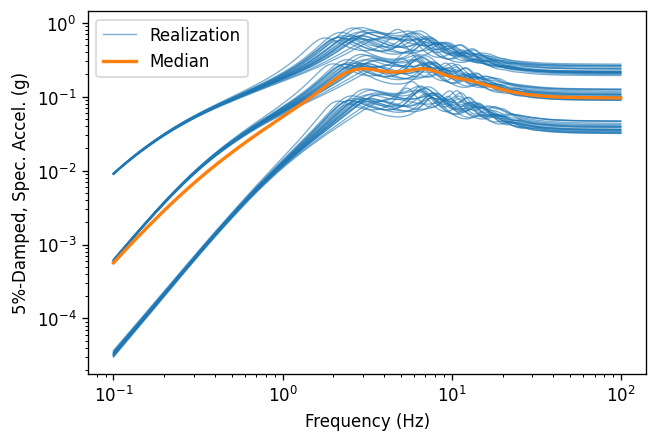

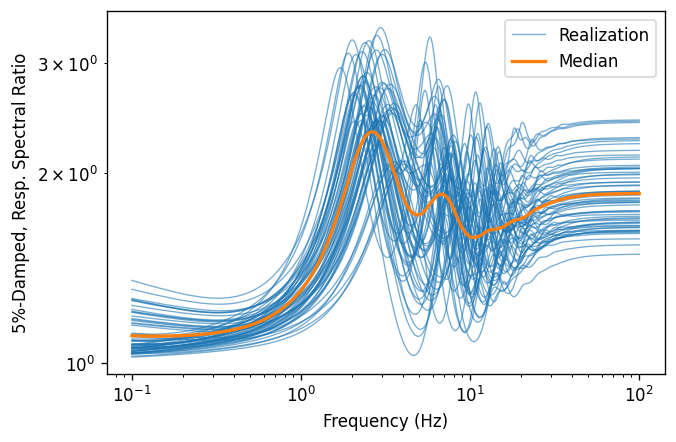

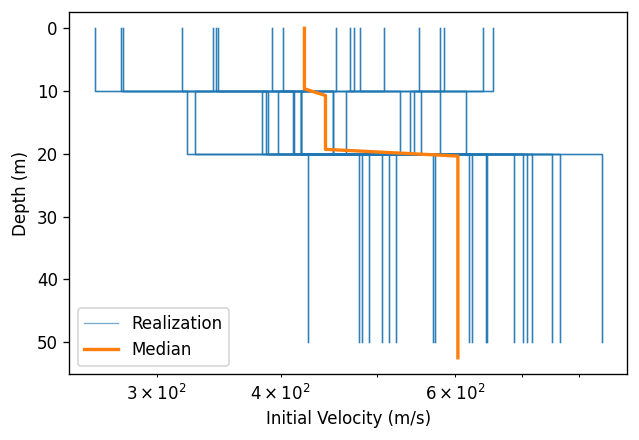

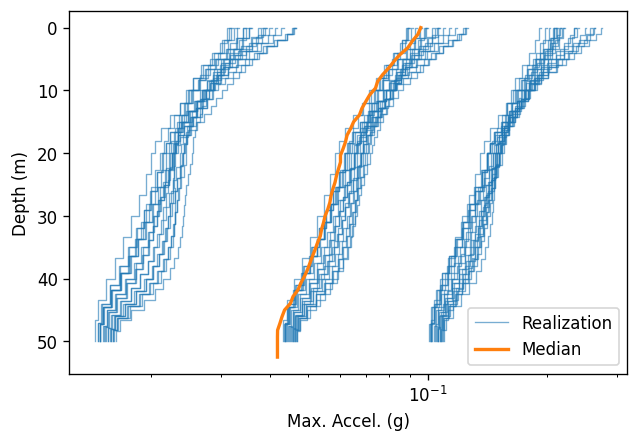

In [9]:
for o in outputs:
    ax = o.plot(style="stats")

## Manipulating output as dataframe

If a `tuple` is passed as the output name, it is used to create a `pandas.MultiIndex` columns.

In [10]:
df = outputs[1].to_dataframe()
df

p0                            p1                      \
                  m0        m1        m2        m0        m1        m2   
0.100000    1.157284  1.054334  1.034153  1.204294  1.069997  1.044491   
0.101394    1.156832  1.054306  1.034424  1.203631  1.069946  1.044834   
0.102807    1.156381  1.054282  1.034697  1.202970  1.069900  1.045181   
0.104240    1.155933  1.054263  1.034973  1.202311  1.069859  1.045532   
0.105693    1.155486  1.054249  1.035252  1.201655  1.069824  1.045886   
...              ...       ...       ...       ...       ...       ...   
94.613238   2.009059  1.912273  1.828188  2.176208  2.059669  1.939314   
95.932095   2.009118  1.912321  1.828257  2.176280  2.059735  1.939407   
97.269336   2.009175  1.912367  1.828323  2.176349  2.059799  1.939496   
98.625218   2.009231  1.912412  1.828387  2.176415  2.059860  1.939583   
100.000000  2.009284  1.912456  1.828449  2.176480  2.059920  1.939667   

                  p2                            p3  ...       p16       p17  \
                  m0        m1        m2        m0  ...        m2        m0   
0.100000    1.259717  1.084809  1.052390  1.146986  ...  1.052542  1.100221   
0.101394    1.258711  1.084728  1.052788  1.146517  ...  1.052941  1.099966   
0.102807    1.257709  1.084653  1.053191  1.146049  ...  1.053344  1.099712   
0.104240    1.256710  1.084584  1.053598  1.145583  ...  1.053751  1.099458   
0.105693    1.255716  1.084522  1.054009  1.145119  ...  1.054163  1.099206   
...              ...       ...       ...       ...  ...       ...       ...   
94.613238   1.967535  1.870110  1.699779  1.650014  ...  1.822188  1.720799   
95.932095   1.967613  1.870194  1.699882  1.650082  ...  1.822294  1.720833   
97.269336   1.967689  1.870275  1.699982  1.650147  ...  1.822397  1.720865   
98.625218   1.967763  1.870354  1.700079  1.650210  ...  1.822497  1.720897   
100.000000  1.967834  1.870430  1.700173  1.650272  ...  1.822593  1.720927   

                                     p18                           p19  \
                  m1        m2        m0        m1        m2        m0   
0.100000    1.033792  1.020442  1.215418  1.071120  1.043652  1.202160   
0.101394    1.033786  1.020610  1.214596  1.071060  1.043991  1.201430   
0.102807    1.033783  1.020780  1.213775  1.071005  1.044333  1.200702   
0.104240    1.033784  1.020951  1.212958  1.070955  1.044678  1.199976   
0.105693    1.033787  1.021125  1.212144  1.070911  1.045028  1.199254   
...              ...       ...       ...       ...       ...       ...   
94.613238   1.651564  1.611563  1.664362  1.616527  1.487430  1.812698   
95.932095   1.651586  1.611594  1.664425  1.616595  1.487512  1.812756   
97.269336   1.651606  1.611623  1.664486  1.616661  1.487591  1.812813   
98.625218   1.651626  1.611651  1.664545  1.616724  1.487668  1.812867   
100.000000  1.651646  1.611678  1.664602  1.616786  1.487743  1.812920   

                                
                  m1        m2  
0.100000    1.067311  1.041442  
0.101394    1.067260  1.041765  
0.102807    1.067212  1.042090  
0.104240    1.067171  1.042420  
0.105693    1.067134  1.042753  
...              ...       ...  
94.613238   1.741944  1.621358  
95.932095   1.742003  1.621432  
97.269336   1.742060  1.621504  
98.625218   1.742115  1.621574  
100.000000  1.742168  1.621641  

[500 rows x 60 columns]

Lets names to the dataframe and transform into a long format. Pandas works better on long formatted tables.

In [11]:
# Add names for clarity
df.columns.names = ("profile", "motion")
df.index.name = "freq"
# Transform into a long format
df = df.reset_index().melt(id_vars="freq")
df

,freq,profile,motion,value
0,0.100000,p0,m0,1.157284
1,0.101394,p0,m0,1.156832
2,0.102807,p0,m0,1.156381
3,0.104240,p0,m0,1.155933
4,0.105693,p0,m0,1.155486
...,...,...,...,...
29995,94.613238,p19,m2,1.621358
29996,95.932095,p19,m2,1.621432
29997,97.269336,p19,m2,1.621504
29998,98.625218,p19,m2,1.621574


In [12]:
def calc_stats(group):
    ln_value = np.log(group["value"])

    median = np.exp(np.mean(ln_value))
    ln_std = np.std(ln_value)

    return pd.Series({"median": median, "ln_std": ln_std})


stats = df.groupby(["freq", "motion"]).apply(calc_stats)
stats

median    ln_std
freq       motion                    
0.100000   m0      1.205047  0.050720
           m1      1.068990  0.018076
           m2      1.043245  0.011920
0.101394   m0      1.204340  0.050512
           m1      1.068936  0.018048
...                     ...       ...
98.625218  m1      1.870490  0.110614
           m2      1.747636  0.101145
100.000000 m0      1.962806  0.123600
           m1      1.870552  0.110617
           m2      1.747717  0.101149

[1500 rows x 2 columns]

In [13]:
stats = (
    stats.reset_index("motion")
    .pivot(columns="motion")
    .swaplevel(0, 1, axis=1)
    .sort_index(axis=1)
)
stats

motion            m0                  m1                  m2          
              ln_std    median    ln_std    median    ln_std    median
freq                                                                  
0.100000    0.050720  1.205047  0.018076  1.068990  0.011920  1.043245
0.101394    0.050512  1.204340  0.018048  1.068936  0.011999  1.043577
0.102807    0.050305  1.203635  0.018022  1.068887  0.012079  1.043913
0.104240    0.050098  1.202933  0.017996  1.068843  0.012160  1.044252
0.105693    0.049892  1.202233  0.017971  1.068804  0.012241  1.044595
...              ...       ...       ...       ...       ...       ...
94.613238   0.123593  1.962534  0.110603  1.870292  0.101132  1.747380
95.932095   0.123595  1.962605  0.110606  1.870360  0.101137  1.747468
97.269336   0.123596  1.962674  0.110610  1.870426  0.101141  1.747554
98.625218   0.123598  1.962741  0.110614  1.870490  0.101145  1.747636
100.000000  0.123600  1.962806  0.110617  1.870552  0.101149  1.747717

[500 rows x 6 columns]

Access the properties of each motion like:

In [14]:
stats["m0"]

,ln_std,median
freq,,
0.100000,0.050720,1.205047
0.101394,0.050512,1.204340
0.102807,0.050305,1.203635
0.104240,0.050098,1.202933
0.105693,0.049892,1.202233
...,...,...
94.613238,0.123593,1.962534
95.932095,0.123595,1.962605
97.269336,0.123596,1.962674


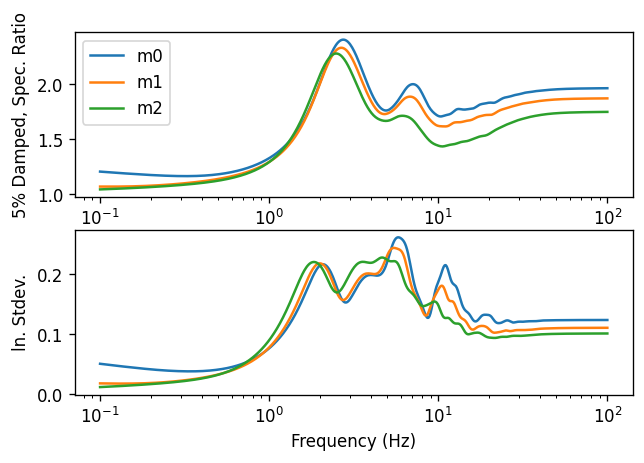

In [15]:
fig, axes = plt.subplots(nrows=2, subplot_kw={"xscale": "log"})

for name, g in stats.groupby(level=0, axis=1):
    for ax, key in zip(axes, ["median", "ln_std"]):
        ax.plot(g.index, g[(name, key)], label=name)


axes[0].set(ylabel="5% Damped, Spec. Ratio")
axes[0].legend()

axes[1].set(ylabel="ln. Stdev.", xlabel="Frequency (Hz)")

fig;